In [133]:
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import gzip
import numpy as np
import seaborn as sns
import itertools
from IPython.display import Markdown, display
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib inline

sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

from sklearn import decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.preprocessing import StandardScaler

In [134]:
n = 5
with open('data/users.csv') as lines:
  for i in range(n):
    print(next(lines))

ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE,STATE,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS

1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,False,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0

545ff94d-66f8-4bea-b398-84425fb2301e,1,GB||JE||IM||GG,False,2018-01-01,2017-03-07 10:18:59.427000,ACTIVE,GB,1982,PASSED,0

10376f1a-a28a-4885-8daa-c8ca496026bb,1,ES,False,2018-09-20,2018-05-31 04:41:24.672000,ACTIVE,ES,1973,PASSED,0

fd308db7-0753-4377-879f-6ecf2af14e4f,1,FR,False,2018-05-25,2018-06-01 17:24:23.852000,ACTIVE,FR,1986,PASSED,0



In [135]:
users = pd.read_csv('data/users.csv')

In [136]:
n = 5
with open('./data/transactions.csv') as transactions:
  for _ in range(n):
    print(next(transactions))

CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,AMOUNT_USD

GBP,4420,COMPLETED,2017-12-10 16:38:55.577,,NLD,chip,3ff52b92-d416-4e22-8cad-018f500d4bbc,ATM,GAIA,367bf5f9-7cce-4683-90b9-d3c011bf4c87,3268.0

PLN,1500,COMPLETED,2017-12-10 16:37:24.792,point_of_interest,POL,manu,76cbaad3-4721-4a3b-92b9-3eb9e9319565,CARD_PAYMENT,GAIA,ff6802b9-360d-4efe-b09b-f99c6cac3383,

GBP,191,COMPLETED,2017-12-10 16:37:16.234,airport,PRT,chip,7bcaa34e-b889-4582-9c29-0b3bab34fb8c,CARD_PAYMENT,GAIA,ddb4a930-7d8a-4f38-9079-ddc4b0db980e,141.0

GBP,10000,COMPLETED,2017-12-10 16:34:42.592,,,misc,b3a6762b-a940-4459-bb1d-8e28e151f901,TOPUP,HERA,080ef0be-850a-4f14-ab03-28ff68e6b797,7394.0



In [137]:
tr = pd.read_csv('./data/transactions.csv')

### Exploratory Data Analysis and Cleaning

Looking at:
Structure: 
  - Reasonable. Loads correctly.

Granularity: 
  - Transactions is at the individual transaction.  There are multiple per user.
  - User is at the user level.  Single per user.
  - When we merge the two data files, the merged data file takes on the granularity of the transaction

Scope:
 - test

Temporality:
 - test

Faithfulness:
 - I'll walk through each field in the next block to examine if the data looks reasonable and if not, how to address it.



### EDA and Faithfulness
We'll look at the User dataset first.

If I don't mention missing values, it will be because there are none and so nothing to address.  The number of missing values will be seen by the following `.info()` call.

We can actually see that only the `Terms_Version` field has missing values. We will look into the nature of these.

In [138]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       9944 non-null   object
 1   HAS_EMAIL                9944 non-null   int64 
 2   PHONE_COUNTRY            9944 non-null   object
 3   IS_FRAUDSTER             9944 non-null   bool  
 4   TERMS_VERSION            8417 non-null   object
 5   CREATED_DATE             9944 non-null   object
 6   STATE                    9944 non-null   object
 7   COUNTRY                  9944 non-null   object
 8   BIRTH_YEAR               9944 non-null   int64 
 9   KYC                      9944 non-null   object
 10  FAILED_SIGN_IN_ATTEMPTS  9944 non-null   int64 
dtypes: bool(1), int64(3), object(7)
memory usage: 786.7+ KB


Notes: Id
  - It is unique(no counts>1) and so leads me to believe that the granularity of the dataset is at the user level.

In [139]:
users['ID'].value_counts().max()

1

## Explore the distributions of each variable in the Users Table

In [140]:
columns = [c for c in users.select_dtypes(include=['object', 'bool']) if c != 'ID']
columns.extend([c for c in users.select_dtypes(include=['int64']) if c != 'ID'])
for column in columns:
    print(f"Value counts for '{column}':")
    print(users[column].value_counts())
    print()



Value counts for 'PHONE_COUNTRY':
PHONE_COUNTRY
GB||JE||IM||GG    4302
FR                1309
PL                 672
LT                 492
ES                 411
                  ... 
CO                   1
GE                   1
OM                   1
AD                   1
CR                   1
Name: count, Length: 83, dtype: int64

Value counts for 'IS_FRAUDSTER':
IS_FRAUDSTER
False    9646
True      298
Name: count, dtype: int64

Value counts for 'TERMS_VERSION':
TERMS_VERSION
2018-05-25    3393
2018-09-20    2109
2018-03-20    2048
2018-01-13     440
2018-01-01     232
2017-01-16     121
2017-02-02      74
Name: count, dtype: int64

Value counts for 'CREATED_DATE':
CREATED_DATE
2017-08-06 07:33:33.341000    1
2018-03-16 14:40:22.272000    1
2018-07-11 19:04:55.634000    1
2018-03-08 18:11:53.408000    1
2016-09-29 18:06:48.830000    1
                             ..
2016-05-06 12:53:19.909000    1
2018-04-27 05:10:31.563000    1
2018-07-01 17:54:56.665000    1
2017-08-14 12:21:

### Notes on data distributions dump
  - Has_email: A boolean in the form of 1/0.
  - Phone_Country: The highest number by far belongs to `GB...GG`.  It may be interesting to split these out into single countries or otherwise look into this field.
  - Terms_Version: We have a limited number of versions and then about 1000 who have no value.  I will make the assumption that those users have never received or signed a "Terms" agreement rather than that this missing data is just invalid.
  - Failed_sign-in-Attempts: A very few have greater than 1
  - KYC: This looks like it may be an interesting field
```
PASSED     6969
NONE       2631
FAILED      270
PENDING      74

```
  - State: This looks like it may be an interesting field
```
  ACTIVE    9646
  LOCKED     298
```


Notes: Created_Date

This will be transformed into a date time.  The value does have both a date and a time.  I'll split it into two fields.  It is possible that there is some relevant information in the time at which the account was created.

In [141]:
users['DT_CREATED_DATETIME'] = pd.to_datetime(users['CREATED_DATE'])
users['DT_CREATED_DATE'] = users['DT_CREATED_DATETIME'].dt.date
users['DT_CREATED_TIME'] = users['DT_CREATED_DATETIME'].dt.time


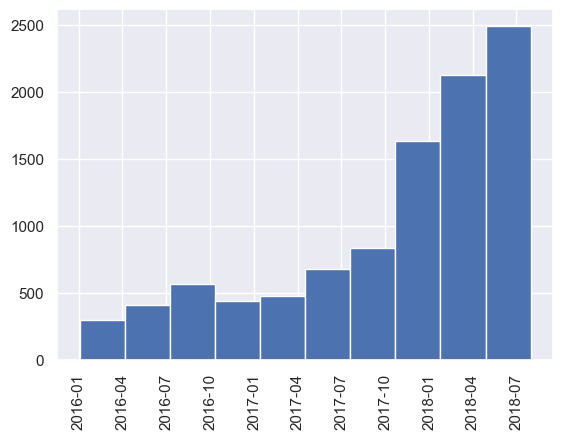

In [142]:
plt.hist(users['DT_CREATED_DATE'])
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.15)
plt.show()


### Exploration of Transaction table

In [143]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688651 entries, 0 to 688650
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CURRENCY           688651 non-null  object 
 1   AMOUNT             688651 non-null  int64  
 2   STATE              688651 non-null  object 
 3   CREATED_DATE       688651 non-null  object 
 4   MERCHANT_CATEGORY  223065 non-null  object 
 5   MERCHANT_COUNTRY   483055 non-null  object 
 6   ENTRY_METHOD       688651 non-null  object 
 7   USER_ID            688651 non-null  object 
 8   TYPE               688651 non-null  object 
 9   SOURCE             688651 non-null  object 
 10  ID                 688651 non-null  object 
 11  AMOUNT_USD         635328 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usage: 63.0+ MB


In [144]:
tr['CREATED_DATE'].head()

0    2017-12-10 16:38:55.577
1    2017-12-10 16:37:24.792
2    2017-12-10 16:37:16.234
3    2017-12-10 16:34:42.592
4     2017-12-10 16:34:17.88
Name: CREATED_DATE, dtype: object

In [145]:
tr['DT_CREATED_DATE'] = pd.to_datetime(tr['CREATED_DATE'], format='mixed').dt.date

In [146]:
tr['DT_CREATED_DATE'].head()

0    2017-12-10
1    2017-12-10
2    2017-12-10
3    2017-12-10
4    2017-12-10
Name: DT_CREATED_DATE, dtype: object

In [147]:
columns = [c for c in tr.select_dtypes(include=['object', 'bool']) if c not in ['ID', 'USER_ID', 'CREATED_DATE']]
columns.extend([c for c in tr.select_dtypes(include=['int64']) if c != ['AMOUNT','AMOUNT_USD']])
for column in columns:
    print(f"Value counts for '{column}':")
    print(tr[column].value_counts())
    print()

Value counts for 'CURRENCY':
CURRENCY
GBP    339091
EUR    264695
USD     31542
PLN     22362
RON      5837
CHF      5761
NOK      2602
AUD      2110
DKK      1711
SEK      1579
CZK      1507
CAD      1463
HUF      1446
ZAR      1126
AED       847
JPY       733
NZD       717
THB       690
ILS       522
SGD       487
HKD       480
TRY       338
BTC       283
INR       207
ETH       197
LTC       137
MAD       115
XRP        38
QAR        28
Name: count, dtype: int64

Value counts for 'STATE':
STATE
COMPLETED    584507
DECLINED      45635
REVERTED      38663
FAILED        16763
PENDING        2477
CANCELLED       515
RECORDED         91
Name: count, dtype: int64

Value counts for 'MERCHANT_CATEGORY':
MERCHANT_CATEGORY
point_of_interest      38809
supermarket            30546
restaurant             23815
cafe                   13138
bar                    13032
                       ...  
archipelago                3
intersection               1
sublocality_level_3        1
physiotherapi

## Relationships Between Factors and Target Variable

/Users/jeschrader/miniconda3/envs/sci-py-env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


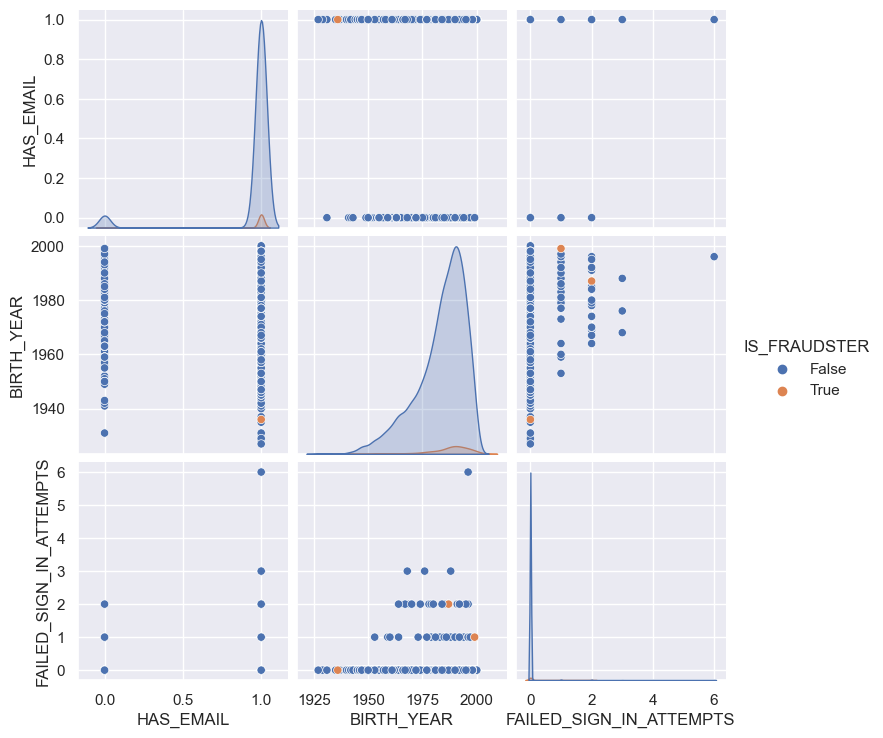

In [148]:
sns.pairplot(users, hue='IS_FRAUDSTER')

In [149]:
columns = [c for c in users.columns if c not in ['ID', 'IS_FRAUDSTER', 'CREATED_DATE', 'DT_CREATED_DATETIME', 'DT_CREATED_TIME']]
for column in columns:
    print(f"Pivot for '{column}' against IS_FRAUDSTER")
    pivoted_df = users.pivot_table(index='IS_FRAUDSTER', columns=column, values='ID', aggfunc='count')
    print(pivoted_df)
    print()

Pivot for 'HAS_EMAIL' against IS_FRAUDSTER
HAS_EMAIL       0     1
IS_FRAUDSTER           
False         529  9117
True            1   297

Pivot for 'PHONE_COUNTRY' against IS_FRAUDSTER
PHONE_COUNTRY   AD   AE   AL   AR    AT   AZ    BE    BG  BL||MF||GP   BN  \
IS_FRAUDSTER                                                                
False          1.0  3.0  2.0  4.0  30.0  1.0  86.0  61.0         3.0  1.0   
True           NaN  NaN  NaN  NaN   NaN  NaN   NaN   NaN         NaN  NaN   

PHONE_COUNTRY  ...    SK   SN  TF||RE||YT    TH   TR   TW   UA  US||PR||CA  \
IS_FRAUDSTER   ...                                                           
False          ...  22.0  1.0         3.0  10.0  5.0  1.0  4.0        18.0   
True           ...   NaN  NaN         NaN   NaN  NaN  NaN  NaN         2.0   

PHONE_COUNTRY   VN   ZA  
IS_FRAUDSTER             
False          2.0  6.0  
True           NaN  NaN  

[2 rows x 83 columns]

Pivot for 'TERMS_VERSION' against IS_FRAUDSTER
TERMS_VERSION  2

### Notes on relationships between factors and target in users table
- STATE: This variable where Locked=True is 100% aligned.  Presumably, this means they've already detected this user was a fraudster.  We can use this variable and be done.  But, that is too easy.
- HAS_EMAIL: correlated

### Relationship between factors and target in transactions table(after merged to get target)

In [150]:
target_df=users[['ID', 'IS_FRAUDSTER']]
tr_with_target = pd.merge(target_df, tr, how='inner', left_on='ID', right_on='USER_ID')

In [151]:
tr_with_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638742 entries, 0 to 638741
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID_x               638742 non-null  object 
 1   IS_FRAUDSTER       638742 non-null  bool   
 2   CURRENCY           638742 non-null  object 
 3   AMOUNT             638742 non-null  int64  
 4   STATE              638742 non-null  object 
 5   CREATED_DATE       638742 non-null  object 
 6   MERCHANT_CATEGORY  208677 non-null  object 
 7   MERCHANT_COUNTRY   447017 non-null  object 
 8   ENTRY_METHOD       638742 non-null  object 
 9   USER_ID            638742 non-null  object 
 10  TYPE               638742 non-null  object 
 11  SOURCE             638742 non-null  object 
 12  ID_y               638742 non-null  object 
 13  AMOUNT_USD         586125 non-null  float64
 14  DT_CREATED_DATE    638742 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(12)
memory

In [152]:
columns = [c for c in tr_with_target.columns if c not in ['ID_x', 'ID_y', 'USER_ID', 'IS_FRAUDSTER', 'AMOUNT', 'AMOUNT_USD', 'CREATED_DATE', 'DT_CREATED_DATE']]
for column in columns:
    print(f"Pivot for '{column}' against IS_FRAUDSTER")
    pivoted_df = tr_with_target.pivot_table(index='IS_FRAUDSTER', columns=column, values='ID_x', aggfunc='count')
    print(pivoted_df)
    print()

Pivot for 'CURRENCY' against IS_FRAUDSTER
CURRENCY        AED     AUD    BTC     CAD     CHF     CZK     DKK    ETH  \
IS_FRAUDSTER                                                                
False         840.0  1999.0  257.0  1431.0  5733.0  1488.0  1681.0  162.0   
True            NaN     NaN    3.0     NaN     1.0     1.0     NaN    NaN   

CURRENCY           EUR       GBP  ...      PLN   QAR     RON     SEK    SGD  \
IS_FRAUDSTER                      ...                                         
False         250082.0  294634.0  ...  22033.0  27.0  5823.0  1578.0  487.0   
True             699.0   12739.0  ...    293.0   NaN    13.0     NaN    NaN   

CURRENCY        THB    TRY      USD   XRP     ZAR  
IS_FRAUDSTER                                       
False         671.0  190.0  27806.0  38.0  1120.0  
True            NaN    NaN    165.0   NaN     NaN  

[2 rows x 29 columns]

Pivot for 'STATE' against IS_FRAUDSTER
STATE         CANCELLED  COMPLETED  DECLINED   FAILED  PENDIN

### Notes on Relationship between factors and target in transactions table(after merged to get target)

Source: "Minos" seems to have a correlation
Amount: I'll need to look at the Amount field manually.  The automated look at the distribution doesn't work well for this type of continuous variable.  I see below that we have some very high numbers for amount and so will look at outliers.

In [153]:
tr[['AMOUNT', 'AMOUNT_USD']].describe()

,AMOUNT,AMOUNT_USD
count,6.886510e+05,6.353280e+05
mean,3.172575e+04,6.856953e+03
std,2.304381e+06,7.441684e+04
min,0.000000e+00,0.000000e+00
25%,4.800000e+02,3.590000e+02
50%,1.420000e+03,1.037000e+03
75%,5.000000e+03,3.713000e+03
max,9.000000e+08,1.641211e+07


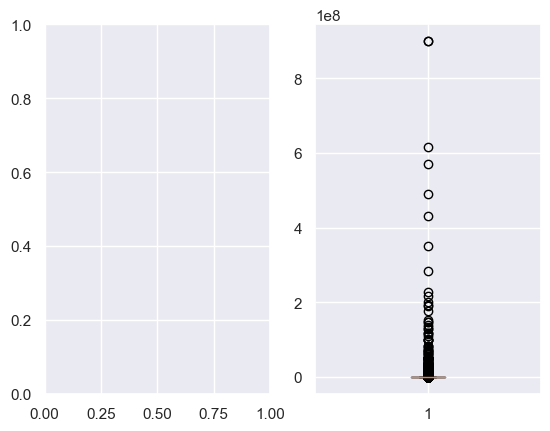

In [154]:

fig, ax = plt.subplots(1, 2)
ax[0] = plt.boxplot(tr['AMOUNT'])
# ax[1] = plt.boxplot(tr['AMOUNT_USD'])
plt.show()

In [155]:
median = 1008
std = 71883
high = median + 1.5 * std
low = median - 1.5 * std
print("IQR =", high - low)
print("Highest =", high) 

tr_with_target['OUTLIER_HIGH'] = False
# set outlier_high to True for all rows where AMOUNT_USD is greater than high
tr_with_target.loc[tr['AMOUNT_USD'] > high, 'OUTLIER_HIGH'] = True


IQR = 215649.0
Highest = 108832.5


In [156]:
tr_with_target['MISSING_AMOUNT_USD'] = False
tr_with_target.loc[tr['AMOUNT_USD'].isna(), 'MISSING_AMOUNT_USD'] = True

In [157]:
res = pd.crosstab(index=tr_with_target['MISSING_AMOUNT_USD'],columns=tr_with_target['IS_FRAUDSTER'], normalize='index') * 100
res

IS_FRAUDSTER,False,True
MISSING_AMOUNT_USD,,
False,97.635563,2.364437
True,100.000000,0.000000


Notes: From above, we can see that none of those missing 'Amount USD' data are associated with fraud.  

In [158]:
pivoted_df = tr_with_target.pivot_table(index='IS_FRAUDSTER', columns='OUTLIER_HIGH', values='ID_x', aggfunc='count')
pivoted_df

OUTLIER_HIGH,False,True
IS_FRAUDSTER,,
False,621011,3817
True,13834,80


In [159]:
median = 1393
std = 2380562
high = median + 1.5 * std
low = median - 1.5 * std
print("IQR =", high - low)
print("Highest =", high) 

tr['OUTLIER_HIGH_2'] = False
# set outlier_high to True for all rows where AMOUNT_USD is greater than high
tr.loc[tr['AMOUNT'] > high, 'OUTLIER_HIGH_2'] = True



IQR = 7141686.0
Highest = 3572236.0


In [160]:
tr["OUTLIER_HIGH_2"].describe()

count     688651
unique         2
top        False
freq      688231
Name: OUTLIER_HIGH_2, dtype: object

### Notes on Amount outliers
From the pivot on Amount outlier and Is_Fraudster, there does not seem to be a correlation. I'll leave the outliers in for now but will consider removing them when modeling.

In [161]:
users["HAS_MULTIPLE_PHONE_COUNTRIES"] = False

users.loc[users["PHONE_COUNTRY"].str.len() > 3, "HAS_MULTIPLE_PHONE_COUNTRIES"] = True


In [162]:
res = pd.crosstab(index=users['HAS_MULTIPLE_PHONE_COUNTRIES'],columns=users['IS_FRAUDSTER'], normalize='index') * 100
res

IS_FRAUDSTER,False,True
HAS_MULTIPLE_PHONE_COUNTRIES,,
False,99.403902,0.596098
True,93.988203,6.011797


### Notes on Phone_Country
Is a correlation between multiple phone countries and target

In [163]:
m = pd.merge(left=users, right=tr, left_on='ID', right_on='USER_ID')

In [164]:
m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638742 entries, 0 to 638741
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   ID_x                          638742 non-null  object        
 1   HAS_EMAIL                     638742 non-null  int64         
 2   PHONE_COUNTRY                 638742 non-null  object        
 3   IS_FRAUDSTER                  638742 non-null  bool          
 4   TERMS_VERSION                 613084 non-null  object        
 5   CREATED_DATE_x                638742 non-null  object        
 6   STATE_x                       638742 non-null  object        
 7   COUNTRY                       638742 non-null  object        
 8   BIRTH_YEAR                    638742 non-null  int64         
 9   KYC                           638742 non-null  object        
 10  FAILED_SIGN_IN_ATTEMPTS       638742 non-null  int64         
 11  DT_CREATED_DA

In [165]:
m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638742 entries, 0 to 638741
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   ID_x                          638742 non-null  object        
 1   HAS_EMAIL                     638742 non-null  int64         
 2   PHONE_COUNTRY                 638742 non-null  object        
 3   IS_FRAUDSTER                  638742 non-null  bool          
 4   TERMS_VERSION                 613084 non-null  object        
 5   CREATED_DATE_x                638742 non-null  object        
 6   STATE_x                       638742 non-null  object        
 7   COUNTRY                       638742 non-null  object        
 8   BIRTH_YEAR                    638742 non-null  int64         
 9   KYC                           638742 non-null  object        
 10  FAILED_SIGN_IN_ATTEMPTS       638742 non-null  int64         
 11  DT_CREATED_DA

In [178]:
X = m[['ID_x', 'HAS_EMAIL', 'TERMS_VERSION',
       'STATE_x', 'COUNTRY', 'BIRTH_YEAR', 'KYC',
       'HAS_MULTIPLE_PHONE_COUNTRIES', 'CURRENCY',
       'AMOUNT', 'STATE_y', 'MERCHANT_CATEGORY',
       'MERCHANT_COUNTRY', 'ENTRY_METHOD', 'TYPE', 'SOURCE', 'OUTLIER_HIGH_2']]
Y = m["IS_FRAUDSTER"]

### Handle Missing Values

In [179]:
X['TERMS_VERSION'] = X['TERMS_VERSION'].fillna('Missing')
X['MERCHANT_CATEGORY'] = X['MERCHANT_CATEGORY'].fillna('Missing')
X['MERCHANT_COUNTRY'] = X['MERCHANT_COUNTRY'].fillna('Missing')

/var/folders/6p/w6jknzqs22lg4wxk1hc9z8q40000gq/T/ipykernel_52943/970525989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['TERMS_VERSION'] = X['TERMS_VERSION'].fillna('Missing')
/var/folders/6p/w6jknzqs22lg4wxk1hc9z8q40000gq/T/ipykernel_52943/970525989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['MERCHANT_CATEGORY'] = X['MERCHANT_CATEGORY'].fillna('Missing')
/var/folders/6p/w6jknzqs22lg4wxk1hc9z8q40000gq/T/ipykernel_52943/970525989.py:3: SettingWithCopyWarning: 
A value is trying to be set 

In [180]:

new_cols = pd.get_dummies(X[["TERMS_VERSION", "KYC", 'STATE_x', 'COUNTRY', 'STATE_y', 'STATE_x', 'CURRENCY', 'MERCHANT_CATEGORY', 'MERCHANT_COUNTRY', 'ENTRY_METHOD', 'TYPE', 'SOURCE']], drop_first=True)
X = pd.concat([X, new_cols], axis=1)

In [181]:
X=X.drop(['TERMS_VERSION', 'KYC', 'STATE_x', 'COUNTRY', 'STATE_y', 'STATE_x', 'CURRENCY', 'MERCHANT_CATEGORY', 'MERCHANT_COUNTRY', 'ENTRY_METHOD', 'TYPE', 'SOURCE'], axis=1)
X.columns

Index(['ID_x', 'HAS_EMAIL', 'BIRTH_YEAR', 'HAS_MULTIPLE_PHONE_COUNTRIES',
       'AMOUNT', 'OUTLIER_HIGH_2', 'TERMS_VERSION_2017-02-02',
       'TERMS_VERSION_2018-01-01', 'TERMS_VERSION_2018-01-13',
       'TERMS_VERSION_2018-03-20',
       ...
       'SOURCE_BRIZO', 'SOURCE_CRONUS', 'SOURCE_GAIA', 'SOURCE_HERA',
       'SOURCE_INTERNAL', 'SOURCE_LETO', 'SOURCE_LIMOS', 'SOURCE_MINOS',
       'SOURCE_NYX', 'SOURCE_OPHION'],
      dtype='object', length=532)

In [183]:
X_For_Corr = X.drop(columns=['ID_x'])
X_corr = X_For_Corr.corr().abs()
X_corr.head()

,HAS_EMAIL,BIRTH_YEAR,HAS_MULTIPLE_PHONE_COUNTRIES,AMOUNT,OUTLIER_HIGH_2,TERMS_VERSION_2017-02-02,TERMS_VERSION_2018-01-01,TERMS_VERSION_2018-01-13,TERMS_VERSION_2018-03-20,TERMS_VERSION_2018-05-25,...,SOURCE_BRIZO,SOURCE_CRONUS,SOURCE_GAIA,SOURCE_HERA,SOURCE_INTERNAL,SOURCE_LETO,SOURCE_LIMOS,SOURCE_MINOS,SOURCE_NYX,SOURCE_OPHION
HAS_EMAIL,1.000000,0.010204,0.029785,0.001176,0.002546,0.004882,0.011240,0.001469,0.010131,0.026399,...,0.000130,0.000229,0.014682,0.009860,0.025462,0.008235,0.003209,0.007394,0.098613,0.008465
BIRTH_YEAR,0.010204,1.000000,0.005100,0.006580,0.011669,0.009935,0.022881,0.041190,0.012849,0.000388,...,0.001146,0.007532,0.010596,0.022569,0.013347,0.010744,0.012541,0.024914,0.009119,0.013449
HAS_MULTIPLE_PHONE_COUNTRIES,0.029785,0.005100,1.000000,0.001307,0.003944,0.042592,0.006117,0.031016,0.049581,0.002830,...,0.001331,0.007993,0.013010,0.017133,0.072717,0.041370,0.025381,0.088789,0.027870,0.018341
AMOUNT,0.001176,0.006580,0.001307,1.000000,0.363612,0.000684,0.000815,0.000035,0.002253,0.000447,...,0.000015,0.022142,0.006882,0.002196,0.004828,0.002262,0.006774,0.000976,0.000314,0.000159
OUTLIER_HIGH_2,0.002546,0.011669,0.003944,0.363612,1.000000,0.001707,0.000831,0.000228,0.002500,0.001345,...,0.000031,0.022122,0.001644,0.010080,0.004937,0.008146,0.022480,0.003180,0.001436,0.000972


<Axes: >

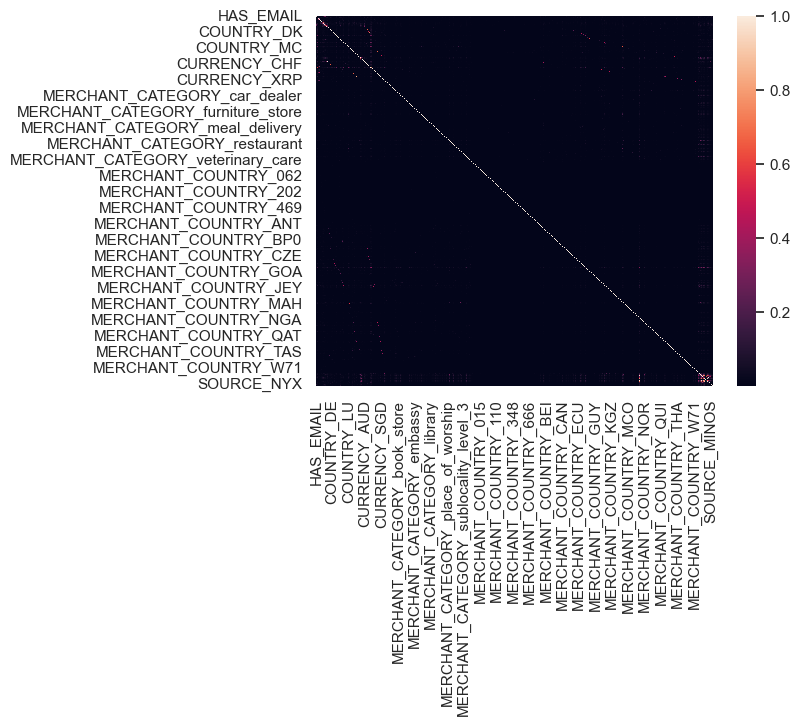

In [184]:
sns.heatmap(X_corr)

In [185]:
res = pd.crosstab(index=tr_with_target['MISSING_AMOUNT_USD'],columns=tr_with_target['IS_FRAUDSTER'], normalize='index') * 100
res

IS_FRAUDSTER,False,True
MISSING_AMOUNT_USD,,
False,97.635563,2.364437
True,100.000000,0.000000


In [189]:
# https://h1ros.github.io/posts/drop-highly-correlated-features/
import numpy as np
threshold = 0.9

columns = np.full((X_corr.shape[0],), True, dtype=bool)
for i in range(X_corr.shape[0]):
    for j in range(i+1, X_corr.shape[0]):
        if X_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
columns = np.insert(columns, 0, True, axis=0)
selected_columns = X.columns[columns]
selected_columns

X = X[selected_columns]

Index(['ID_x', 'HAS_EMAIL', 'BIRTH_YEAR', 'HAS_MULTIPLE_PHONE_COUNTRIES',
       'AMOUNT', 'OUTLIER_HIGH_2', 'TERMS_VERSION_2017-02-02',
       'TERMS_VERSION_2018-01-01', 'TERMS_VERSION_2018-01-13',
       'TERMS_VERSION_2018-03-20',
       ...
       'TYPE_CARD_PAYMENT', 'TYPE_P2P', 'TYPE_TOPUP', 'SOURCE_BRIZO',
       'SOURCE_CRONUS', 'SOURCE_LETO', 'SOURCE_LIMOS', 'SOURCE_MINOS',
       'SOURCE_NYX', 'SOURCE_OPHION'],
      dtype='object', length=527)

In [210]:
# We need to remove 'STATE_x_LOCKED' because it predicts fraud 100%
cols = [c for c in X.columns if c.startswith('STATE')]
cols

['STATE_x_LOCKED',
 'STATE_y_COMPLETED',
 'STATE_y_DECLINED',
 'STATE_y_FAILED',
 'STATE_y_PENDING',
 'STATE_y_RECORDED',
 'STATE_y_REVERTED',
 'STATE_x_LOCKED']

In [211]:
X[['STATE_x_LOCKED']]

,STATE_x_LOCKED,STATE_x_LOCKED
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
638737,False,False
638738,False,False
638739,False,False
638740,False,False


In [213]:
from sklearn.model_selection import train_test_split
X.drop(columns=['ID_x'], inplace=True)
X.drop(columns=['STATE_x_LOCKED'], inplace=True)
y = Y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [214]:
X_train.columns

Index(['HAS_EMAIL', 'BIRTH_YEAR', 'HAS_MULTIPLE_PHONE_COUNTRIES', 'AMOUNT',
       'OUTLIER_HIGH_2', 'TERMS_VERSION_2017-02-02',
       'TERMS_VERSION_2018-01-01', 'TERMS_VERSION_2018-01-13',
       'TERMS_VERSION_2018-03-20', 'TERMS_VERSION_2018-05-25',
       ...
       'SOURCE_BRIZO', 'SOURCE_CRONUS', 'SOURCE_GAIA', 'SOURCE_HERA',
       'SOURCE_INTERNAL', 'SOURCE_LETO', 'SOURCE_LIMOS', 'SOURCE_MINOS',
       'SOURCE_NYX', 'SOURCE_OPHION'],
      dtype='object', length=529)

In [215]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[["AMOUNT"]])

StandardScaler()

In [216]:
X_train[["AMOUNT"]] = scaler.transform(X_train[["AMOUNT"]])
X_test[["AMOUNT"]] = scaler.transform(X_test[["AMOUNT"]])

In [217]:
X_train[["AMOUNT"]].describe()

,AMOUNT
count,5.109930e+05
mean,5.909683e-19
std,1.000001e+00
min,-1.314640e-02
25%,-1.296059e-02
50%,-1.259217e-02
75%,-1.115276e-02
max,3.588418e+02


## Modeling
Below, we'll try multiple models.

I'm going to remove the `State` variable because it predicts `Is_Fraudster` 100%.  Maybe this was the answer to the original exercise, but that is too easy.  The following models become 100% accurate when I leave that feature in to model upon.

### Models
1. LogisticRegression
  - LogisticRegression class
    - F1 score is terrible(45)
  - LogisticRegressionCV class
    - currently failing due to inability to minimize.
2. Decision Tree
  - Working much better 
  - F1 score of 76
3. Random Forest
  - Even better
  - F1 score of 78

### Evaluation
1. sci-kit `accuracy_score`
  - Number of correctly labelled items over total items
  - This score's issue in this dataset particularly is that we get 98% and yet only identify 50% of the fraudulent transactions.  This is because the vast majority of the transactions are not fraudulent and by skewing toward false negatives, our score is high.
2. F1 score
  - The F1 score(and its component scores) from our first modeling runs show that we have not been very successful and need to iterate.
```
  TP: 846
  FP: 256
  FN: 1913
  Precision:  0.7676950998185118
  Recall:  0.3066328379847771
  F1 Score:  0.4382284382284382
```
  - F1 score from best model, Random Forest. Much better than LogisticRegression but still missing 700 fraud transactions
  ```
  TP: 2036
  FP: 366
  FN: 723
  Precision:  0.8476269775187344
  Recall:  0.7379485320768394
  F1 Score:  0.7889943809339276
  ```


In [252]:
def F1_score(predictions, targets):
  zipped = np.column_stack((predictions, np.array(targets)))
  df_z = pd.DataFrame(zipped)
  TP = df_z[(df_z[0] == 1) & (df_z[1] == 1)]
  FP = df_z[(df_z[0] == 1) & (df_z[1] == 0)]
  FN = df_z[(df_z[0] == 0) & (df_z[1] == 1)]

  tp_c = TP.shape[0]
  fp_c = FP.shape[0]
  fn_c = FN.shape[0]

  print('TP:', TP.shape[0])
  print('FP:', FP.shape[0])
  print('FN:', FN.shape[0])

  precision = tp_c/(fp_c + tp_c)
  recall = tp_c/(tp_c + fn_c)
  f1_score = 2 * (precision * recall) / (precision + recall)  
  print("Precision: ", precision)
  print("Recall: ", recall)
  print("F1 Score: ", f1_score) 

In [255]:
def accuracy_evaluation(predictions, targets):
  print("predictions:")
  predictions = pd.DataFrame(predictions)
  print(predictions.value_counts())
  print('')
  print("targets:", targets.value_counts())
  print("testing accuracy",accuracy_score(targets, predictions))
  print('')
  print ('Manual Accuracy of logistic regression(percentage of correctly labelled datapoints):')
  print(float((np.dot(targets,predictions) + np.dot(1-targets,1-predictions))/float(targets.size)*100))

  F1Score(predictions, targets)

In [232]:
def regression_evaluation():
  from sklearn.metrics import mean_absolute_error,mean_squared_error
  mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
  mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
  rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)

  print('MAE: ', mae)
  print('MSE: ', mse)
  print('RMSE: ', rmse)

In [223]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# call predict directly
y_pred = lr.predict(X_test)
res = pd.DataFrame(y_pred)

# use API to call predict and match this against targets
lr.score(X_test, y_test)



y_pred: False    126647
True       1102
Name: count, dtype: int64
y_test: IS_FRAUDSTER
False    124990
True       2759
Name: count, dtype: int64
testing accuracy 0.9830213935138435


In [ ]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV()
clf.fit(X_train, y_train_num)
LR_predictions = clf.predict(X_test)

print(pd.DataFrame(LR_predictions).value_counts())
print(y_test_num.value_counts())
print ('Accuracy of logistic regression: %d ' % float((np.dot(y_test_num,LR_predictions) + np.dot(1-y_test_num,1-LR_predictions))/float(y_test.size)*100) +
           '% ' + "(percentage of correctly labelled datapoints)")


In [237]:
# check multi-collinearity
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(X))
df_pca.head()


,0,1
0,17521.289855,13.941093
1,-7478.710145,13.942211
2,-30258.710146,13.943009
3,-31288.710146,13.940617
4,-31478.710145,13.942432


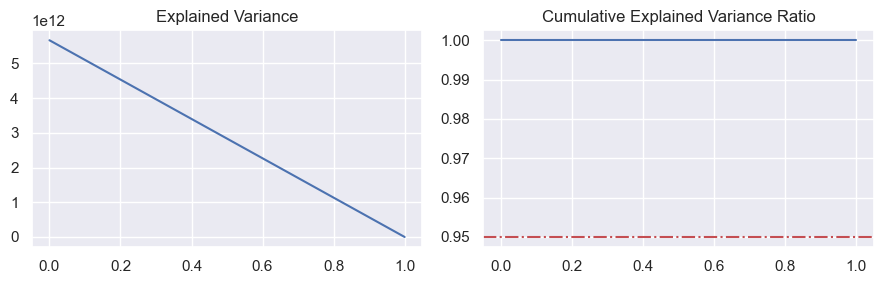

In [238]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
axes[0].plot(pca.explained_variance_);
axes[0].set_title('Explained Variance')
axes[1].plot(np.cumsum(pca.explained_variance_ratio_));
axes[1].axhline(y=0.95, c='r', ls='-.')
axes[1].set_title('Cumulative Explained Variance Ratio')
plt.tight_layout()

In [239]:
pca = PCA(n_components=2, copy=True, whiten=False, tol=0.0)
pca.fit(X)
X_pca = pca.transform(X)


In [240]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


In [241]:
pca_lr = LogisticRegression()
pca_lr.fit(X_train, y_train)
y_pred = pca_lr.predict(X_test)
F1Score(y_pred, y_test)

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [249]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

tree_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()

tree_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [256]:
tree_preds = tree_model.predict(X_test)
print("Decision Tree testing accuracy")
accuracy_evaluation(tree_preds, y_test)

rf_preds = rf_model.predict(X_test)
print("Random Forest testing accuracy")
accuracy_evaluation(rf_preds, y_test)


Decision Tree testing accuracy
predictions:
False    125099
True       2650
Name: count, dtype: int64

targets: IS_FRAUDSTER
False    124990
True       2759
Name: count, dtype: int64
testing accuracy 0.9898942457475205

Manual Accuracy of logistic regression(percentage of correctly labelled datapoints):
97.37845306029793
TP: 2059
FP: 591
FN: 700
Precision:  0.7769811320754717
Recall:  0.7462848858281986
F1 Score:  0.7613237197263819


/var/folders/6p/w6jknzqs22lg4wxk1hc9z8q40000gq/T/ipykernel_52943/2889587777.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(float((np.dot(targets,predictions) + np.dot(1-targets,1-predictions))/float(targets.size)*100))


Random Forest testing accuracy
predictions:
False    125347
True       2402
Name: count, dtype: int64

targets: IS_FRAUDSTER
False    124990
True       2759
Name: count, dtype: int64
testing accuracy 0.9914754714322617

Manual Accuracy of logistic regression(percentage of correctly labelled datapoints):
97.5545796835983
TP: 2036
FP: 366
FN: 723
Precision:  0.8476269775187344
Recall:  0.7379485320768394
F1 Score:  0.7889943809339276


/var/folders/6p/w6jknzqs22lg4wxk1hc9z8q40000gq/T/ipykernel_52943/2889587777.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(float((np.dot(targets,predictions) + np.dot(1-targets,1-predictions))/float(targets.size)*100))
